In [367]:
import pandas as pd
import numpy as numpy
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import warnings

import importlib
import src.preprocess_functions as pp
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

importlib.reload(pp)

<module 'src.preprocess_functions' from '/Users/simon/Desktop/personal/immo_datacollection/house_scraping_project/src/preprocess_functions.py'>

In [368]:
warnings.filterwarnings("ignore", category=FutureWarning)
pd.set_option('display.max_columns', None)

# Augment data
Add features like price_per_sq_meter

In [369]:
df = pd.read_csv('outputs/property_data_raw.csv')
df = pp.preprocess(df)
df

Summary for number_of_bedrooms:
Coefficients: [0.00765965 0.76765569]
Intercept: 1.2253806799848974
Mean Squared Error: 1.092896174863388
R-squared: 0.383896006733377

Summary for number_of_toilets:
Coefficients: [0.00385667 0.01196084 0.19151523]
Intercept: 0.45140902441433184
Mean Squared Error: 0.4813953488372093
R-squared: 0.3144850743969686

Summary for number_of_bathrooms:
Coefficients: [-3.89068646e-04 -3.13122043e-01  1.65865861e-01  5.10319328e-01]
Intercept: 0.2563433579905714
Mean Squared Error: 0.3228346456692913
R-squared: 0.38515129151291516

Summary for cadastral_income:
Coefficients: [ 1.94376924 22.80622826]
Intercept: 277.32192690745
Mean Squared Error: 452810.96119402983
R-squared: -0.4516784111122445



,property_id,date_obtained,price,livable_area,heating_type,has_photovoltaic_panels,has_double_glazing,number_of_bathrooms,number_of_bedrooms,number_of_toilets,has_living_room,has_attic,has_basement,has_terrace,terrace_surface,has_garden,garden_surface,energy_label,primary_energy_consumption,postal_code,latitude,longitude,year_built,building_condition,property_size,flood_zone_type,cadastral_income,age,property_type_HOUSE
16,11326221,2024-07-20,279.0,94.0,GAS,False,True,1.0,2.0,1.0,True,False,True,True,0.0,False,0.0,B,178.0,9040,51.073625,3.747233,1965.0,GOOD,NaN,NON_FLOOD_ZONE,686.0,59.0,False
46,11469558,2024-07-20,495.0,95.0,Unknown,True,True,1.0,2.0,1.0,True,False,False,True,0.0,False,0.0,A,81.0,9000,51.030090,3.715725,2023.0,GOOD,NaN,NON_FLOOD_ZONE,1368.0,1.0,False
76,20011432,2024-07-20,299.0,144.0,GAS,False,True,1.0,4.0,1.0,True,False,True,False,0.0,False,0.0,D,359.0,9000,51.067624,3.729731,1850.0,GOOD,60.0,NON_FLOOD_ZONE,881.0,174.0,True
79,11376909,2024-07-20,269.0,99.0,Unknown,False,True,1.0,2.0,2.0,False,False,False,False,0.0,False,0.0,B,141.0,9050,51.038280,3.747692,1960.0,TO_BE_DONE_UP,NaN,NON_FLOOD_ZONE,800.0,64.0,False
105,11362707,2024-05-19,563.0,187.0,Unknown,False,True,1.0,4.0,1.0,True,False,True,False,0.0,False,0.0,B,172.0,9000,51.026915,3.707021,1954.0,GOOD,230.0,Unknown,937.0,70.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52652,11473871,2024-07-20,268.8,73.0,Unknown,False,False,1.0,2.0,1.0,True,False,False,True,2.0,False,0.0,C,214.0,9050,51.034019,3.763706,1955.0,GOOD,NaN,NON_FLOOD_ZONE,800.0,69.0,False
52658,11449124,2024-06-13,895.0,256.0,GAS,True,True,1.0,3.0,2.0,True,False,False,False,0.0,False,0.0,A,47.0,9940,51.120405,3.668629,2011.0,AS_NEW,1033.0,NON_FLOOD_ZONE,1262.0,13.0,True
52671,11136161,2024-05-28,249.0,66.0,GAS,False,True,1.0,2.0,1.0,True,False,False,True,2.0,False,0.0,D,328.0,9000,51.073445,3.712818,1965.0,GOOD,NaN,NON_FLOOD_ZONE,761.0,59.0,False
52686,11443846,2024-06-24,399.0,169.0,ELECTRIC,False,True,1.0,3.0,2.0,True,True,False,False,0.0,False,0.0,E,453.0,9040,51.062709,3.753197,1992.0,Unknown,313.0,NON_FLOOD_ZONE,1001.0,32.0,True


In [370]:
df['primary_energy_consumption'] = df.groupby('energy_label')['primary_energy_consumption'].transform(
    lambda x: x.fillna(x.mean())
)

/var/folders/qq/3m8nq_ls0rj7d75bks5prfyw0000gn/T/ipykernel_3330/4060428032.py:5: MatplotlibDeprecationWarning:

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.



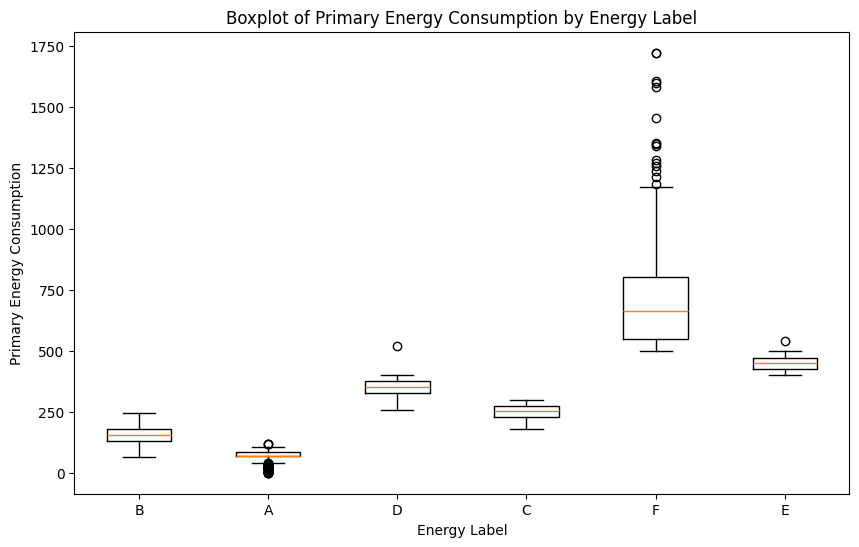

In [371]:
labels = df['energy_label'].unique()
data_to_plot = [df[df['energy_label'] == label]['primary_energy_consumption'].dropna() for label in labels]

plt.figure(figsize=(10, 6))
plt.boxplot(data_to_plot, labels=labels)
plt.xlabel('Energy Label')
plt.ylabel('Primary Energy Consumption')
plt.title('Boxplot of Primary Energy Consumption by Energy Label')
plt.show()

In [377]:
df[df.property_size.isna()].property_type_HOUSE.value_counts()

property_type_HOUSE
False    1196
Name: count, dtype: int64

In [ ]:
df.prop

<class 'pandas.core.frame.DataFrame'>
Index: 2805 entries, 16 to 52700
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   property_id                 2805 non-null   int64         
 1   date_obtained               2805 non-null   datetime64[ns]
 2   price                       2805 non-null   float64       
 3   livable_area                2805 non-null   float64       
 4   heating_type                2805 non-null   object        
 5   has_photovoltaic_panels     2805 non-null   object        
 6   has_double_glazing          2805 non-null   object        
 7   number_of_bathrooms         2805 non-null   float64       
 8   number_of_bedrooms          2805 non-null   float64       
 9   number_of_toilets           2805 non-null   float64       
 10  has_living_room             2805 non-null   bool          
 11  has_attic                   2805 non-null   object        


,property_id,date_obtained,price,livable_area,heating_type,has_photovoltaic_panels,has_double_glazing,number_of_bathrooms,number_of_bedrooms,number_of_toilets,has_living_room,has_attic,has_basement,has_terrace,terrace_surface,has_garden,garden_surface,energy_label,primary_energy_consumption,postal_code,latitude,longitude,year_built,building_condition,property_size,flood_zone_type,cadastral_income,age,property_type_HOUSE
count,2.805000e+03,2805,2805.000000,2805.000000,2805,2805,2805,2805.000000,2805.000000,2805.000000,2805,2805,2805,2805,2805.000000,2805,2805.000000,2805,2805.000000,2805.000000,2805.000000,2805.000000,1887.000000,2805,1609.000000,2805,2805.000000,1887.000000,2805
unique,NaN,NaN,NaN,NaN,6,3,3,NaN,NaN,NaN,2,2,2,2,NaN,2,NaN,6,NaN,NaN,NaN,NaN,NaN,8,NaN,8,NaN,NaN,2
top,NaN,NaN,NaN,NaN,GAS,False,True,NaN,NaN,NaN,False,False,False,False,NaN,False,NaN,B,NaN,NaN,NaN,NaN,NaN,GOOD,NaN,NON_FLOOD_ZONE,NaN,NaN,True
freq,NaN,NaN,NaN,NaN,1425,1386,2124,NaN,NaN,NaN,1484,2495,2193,1686,NaN,2336,NaN,856,NaN,NaN,NaN,NaN,NaN,1035,NaN,2069,NaN,NaN,1609
mean,1.225890e+07,2024-06-26 10:43:15.080214016,443.822543,148.623173,NaN,NaN,NaN,1.284135,2.793939,1.573619,NaN,NaN,NaN,NaN,5.264528,NaN,36.201070,NaN,264.600571,9109.401070,51.055562,3.722815,1964.563328,NaN,429.212554,NaN,1112.778966,59.436672,NaN
min,9.354334e+06,2024-05-16 00:00:00,25.000000,13.000000,NaN,NaN,NaN,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,NaN,0.000000,9000.000000,50.941674,3.597145,1759.000000,NaN,0.000000,NaN,1.000000,-1.000000,NaN
25%,1.134750e+07,2024-05-28 00:00:00,280.000000,90.000000,NaN,NaN,NaN,1.000000,2.000000,1.000000,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,NaN,133.000000,9000.000000,51.037694,3.706946,1938.000000,NaN,70.000000,NaN,637.000000,23.000000,NaN
50%,1.140624e+07,2024-06-24 00:00:00,370.000000,130.000000,NaN,NaN,NaN,1.000000,3.000000,1.000000,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,NaN,218.000000,9000.000000,51.053872,3.723944,1969.000000,NaN,148.000000,NaN,875.000000,55.000000,NaN
75%,1.145981e+07,2024-07-20 00:00:00,488.000000,176.000000,NaN,NaN,NaN,1.000000,3.000000,2.000000,NaN,NaN,NaN,NaN,1.000000,NaN,0.000000,NaN,338.000000,9041.000000,51.066796,3.742553,2001.000000,NaN,370.000000,NaN,1134.000000,86.000000,NaN
max,2.002474e+07,2024-07-20 00:00:00,4450.000000,1300.000000,NaN,NaN,NaN,14.000000,14.000000,9.000000,NaN,NaN,NaN,NaN,265.000000,NaN,5020.000000,NaN,1723.000000,9940.000000,51.198264,3.835605,2025.000000,NaN,37658.000000,NaN,396751.000000,265.000000,NaN


property_id                      0
date_obtained                    0
price                            0
livable_area                     0
heating_type                     0
has_photovoltaic_panels          0
has_double_glazing               0
number_of_bathrooms              0
number_of_bedrooms               0
number_of_toilets                0
has_living_room                  0
has_attic                        0
has_basement                     0
has_terrace                      0
terrace_surface                  0
has_garden                       0
garden_surface                   0
energy_label                     0
primary_energy_consumption       0
postal_code                      0
latitude                         0
longitude                        0
year_built                     918
building_condition               0
property_size                 1196
flood_zone_type                  0
cadastral_income                 0
age                            918
property_type_HOUSE 

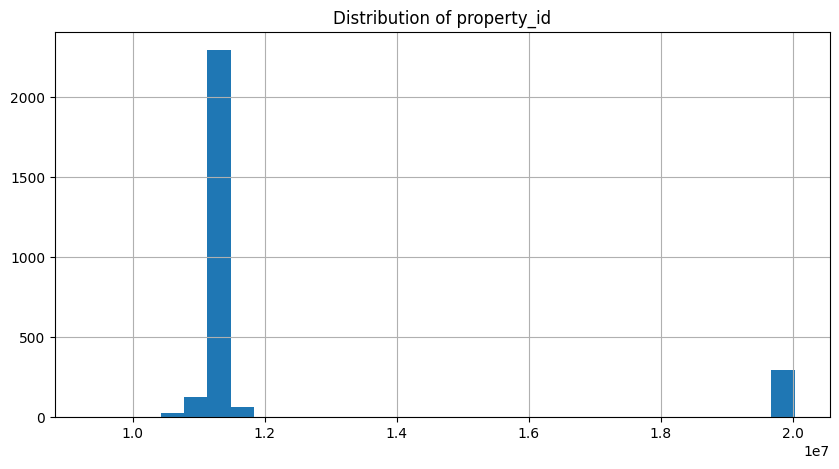

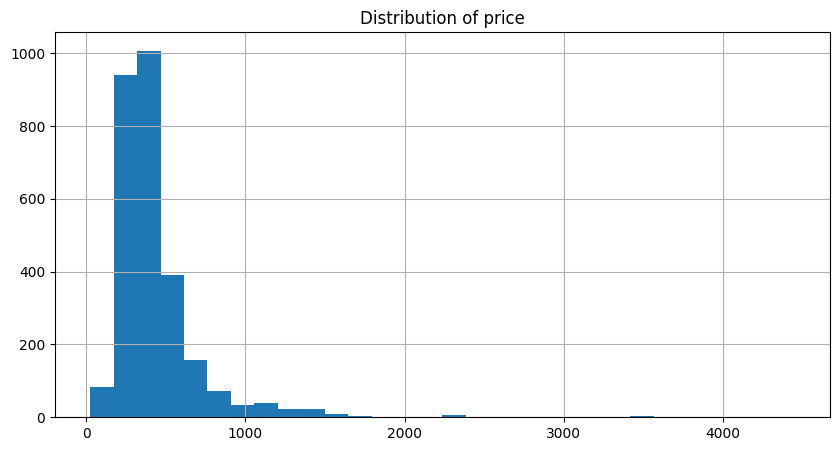

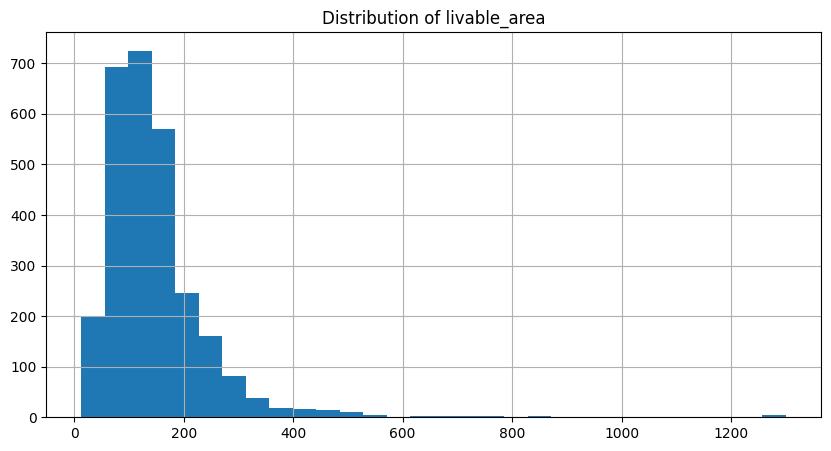

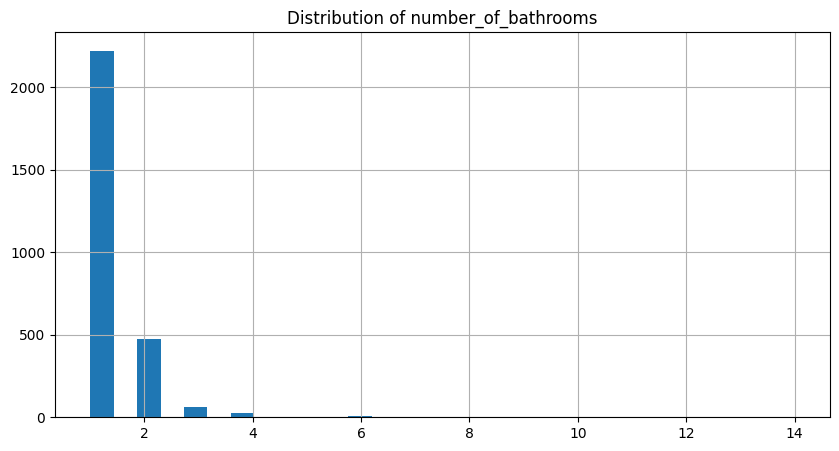

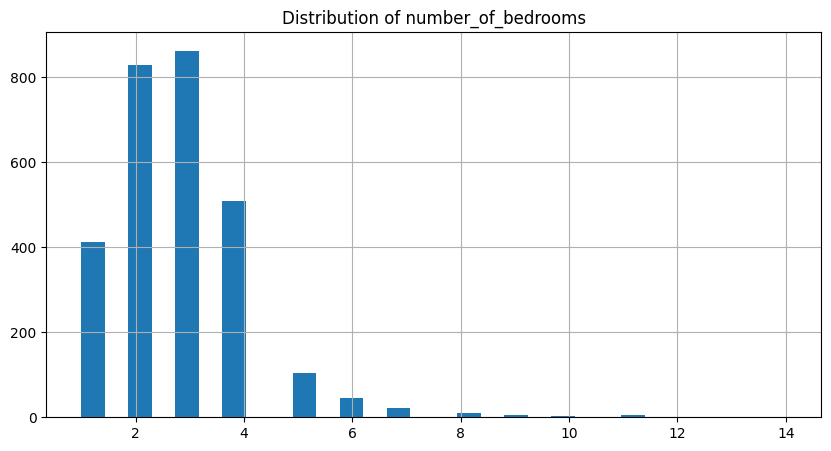

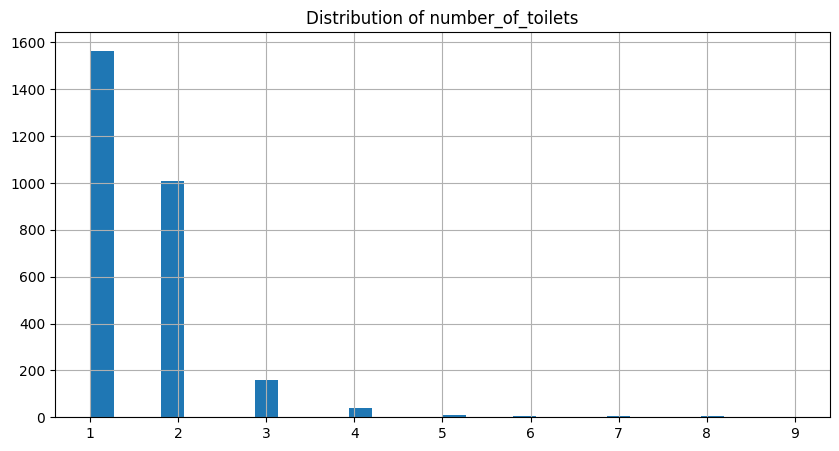

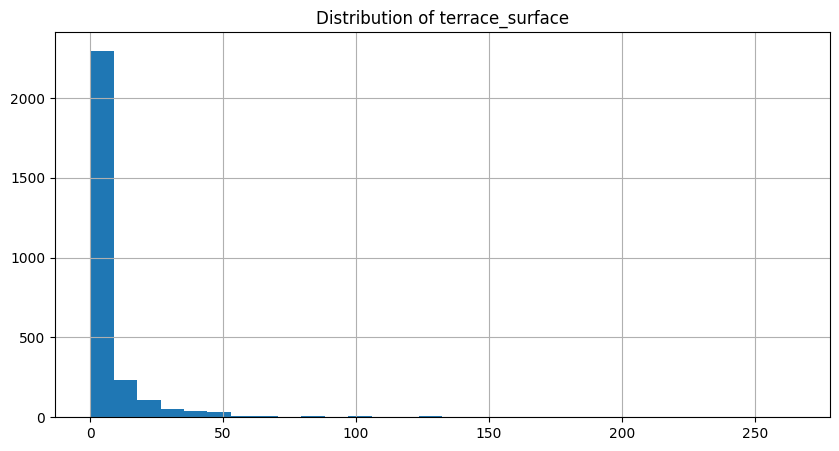

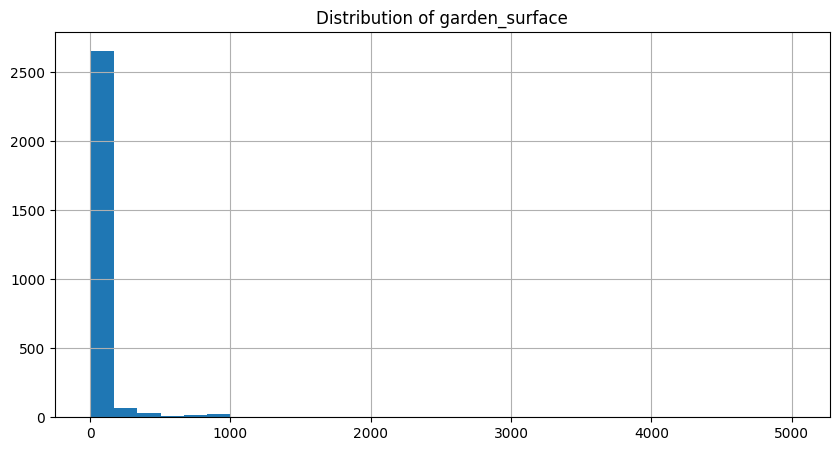

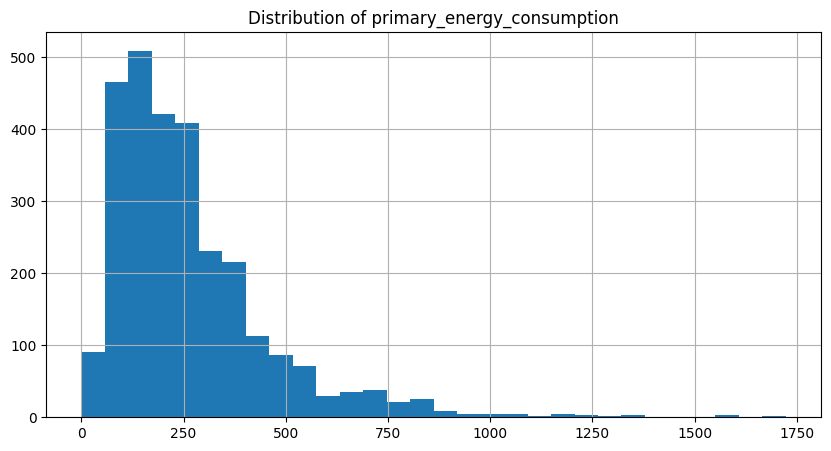

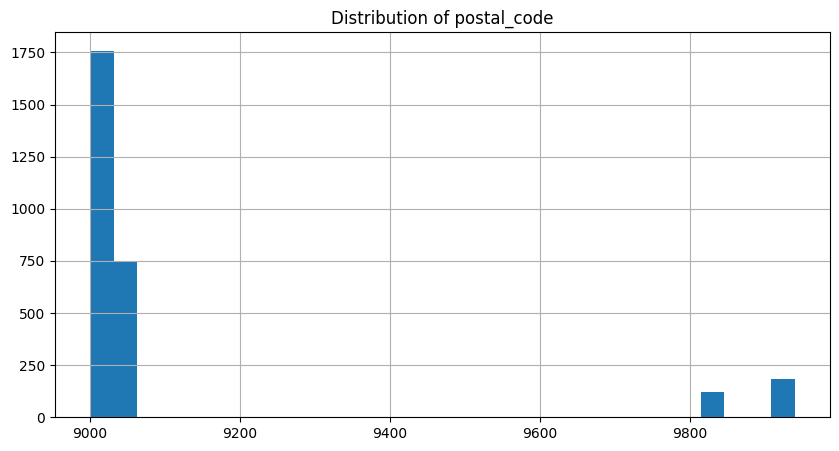

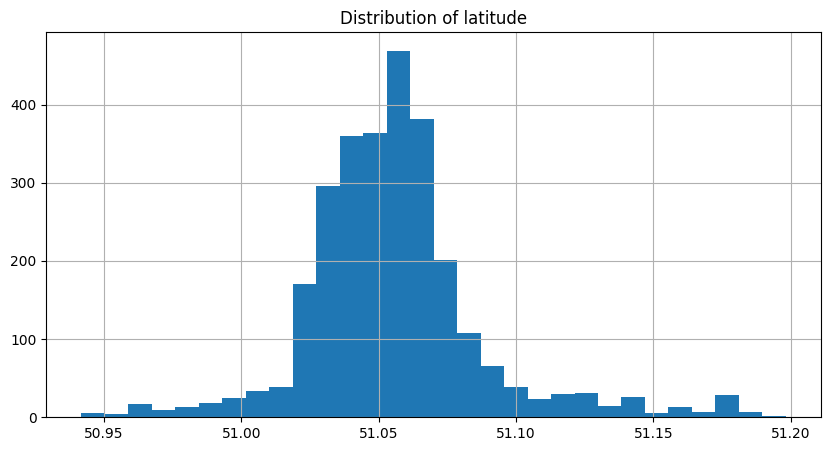

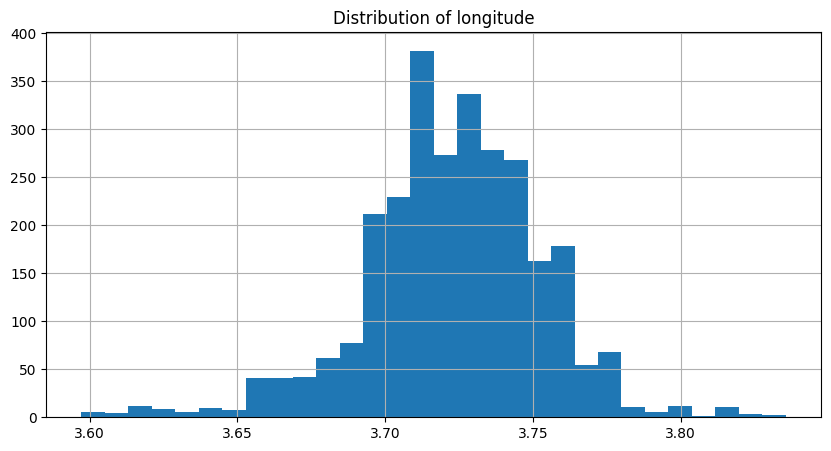

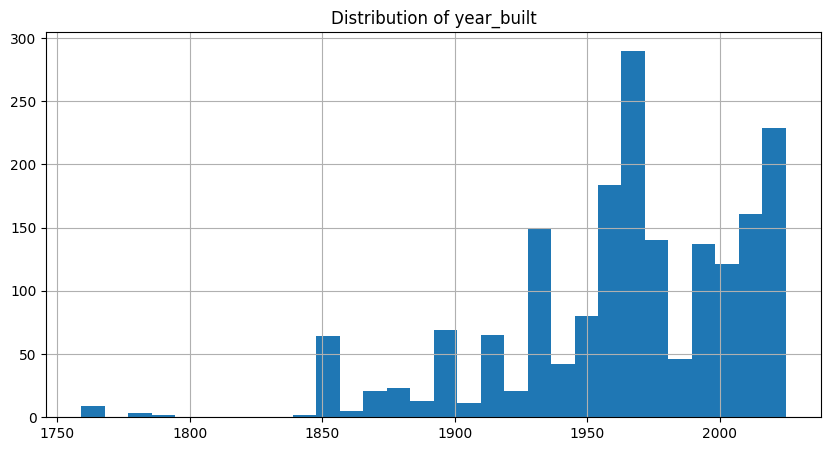

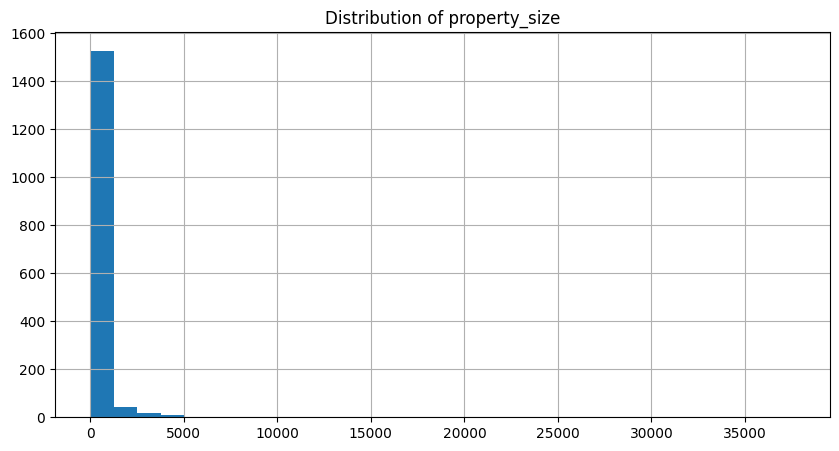

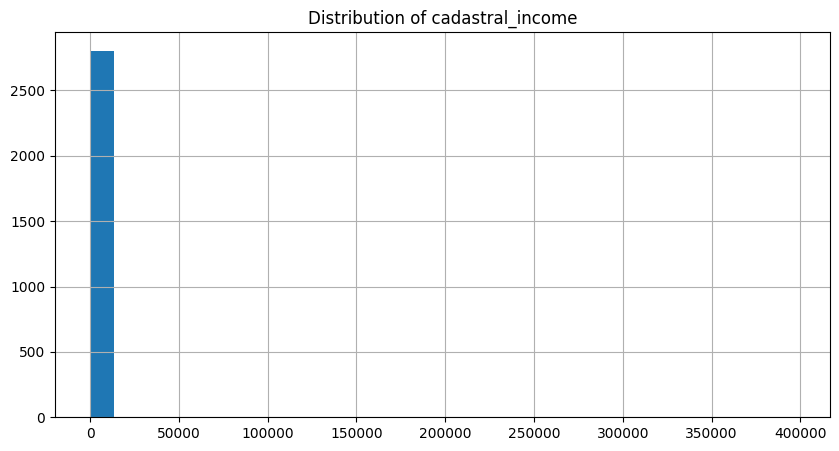

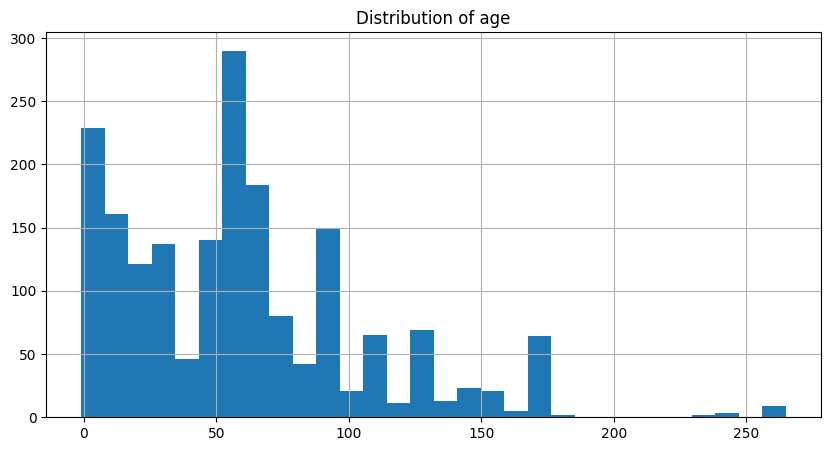

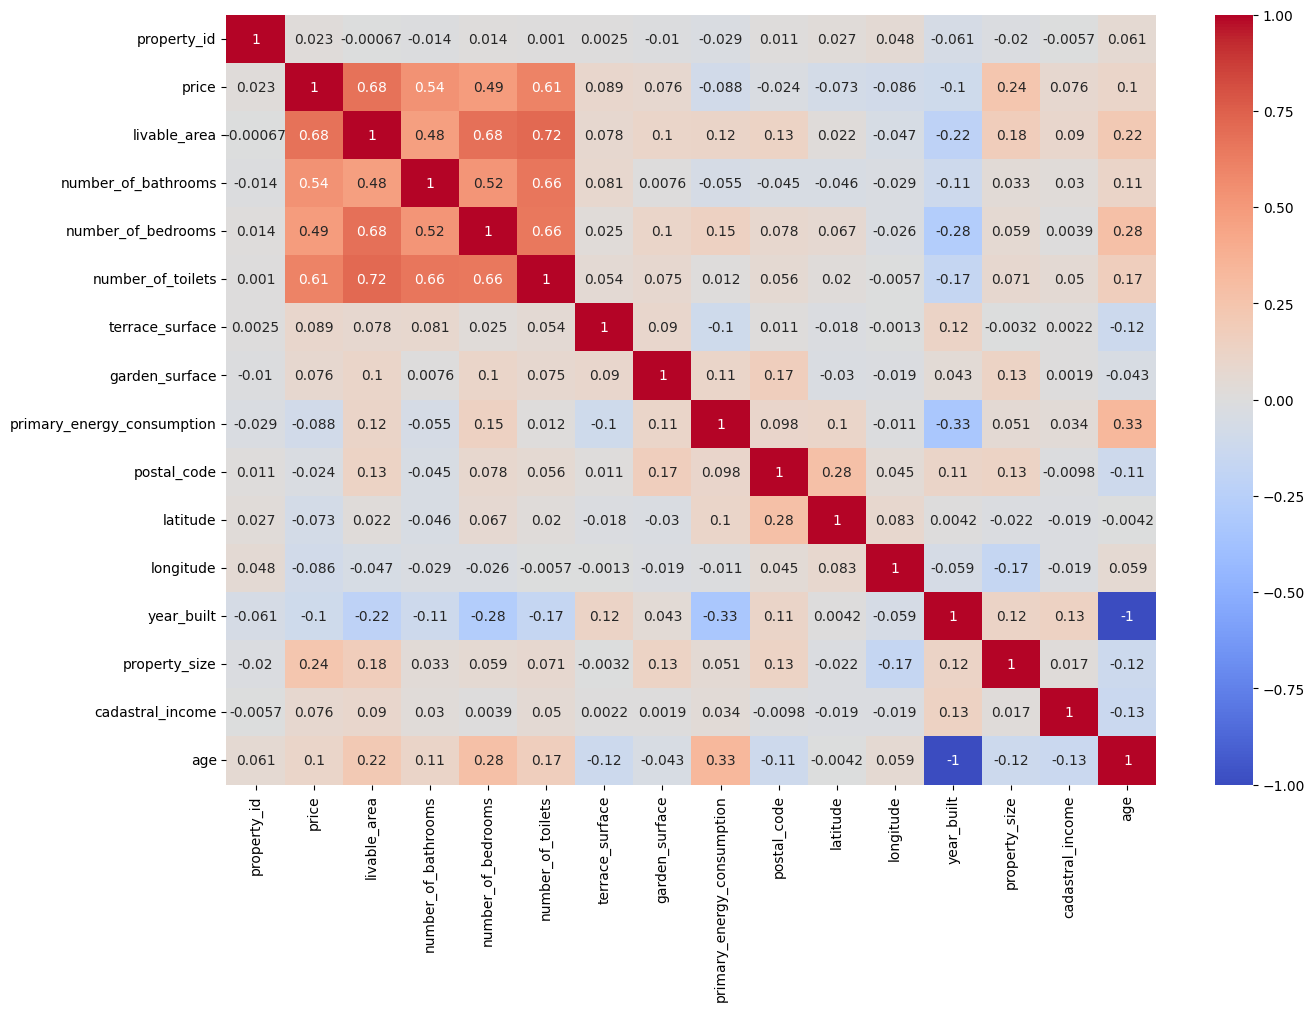

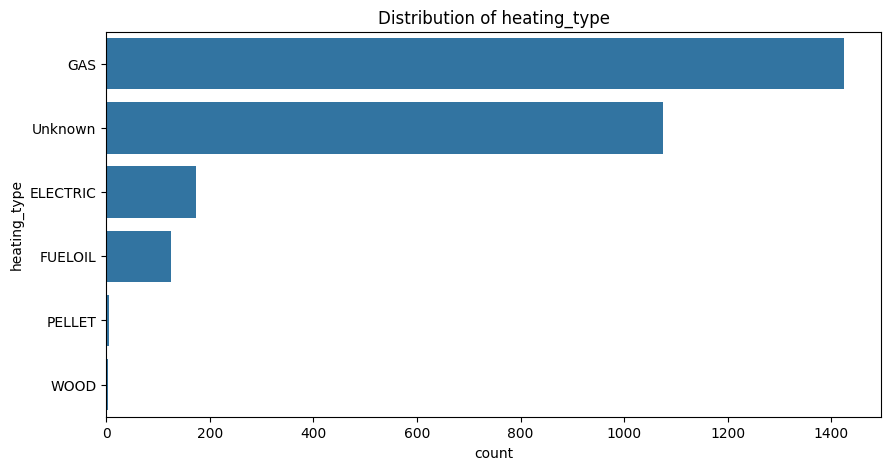

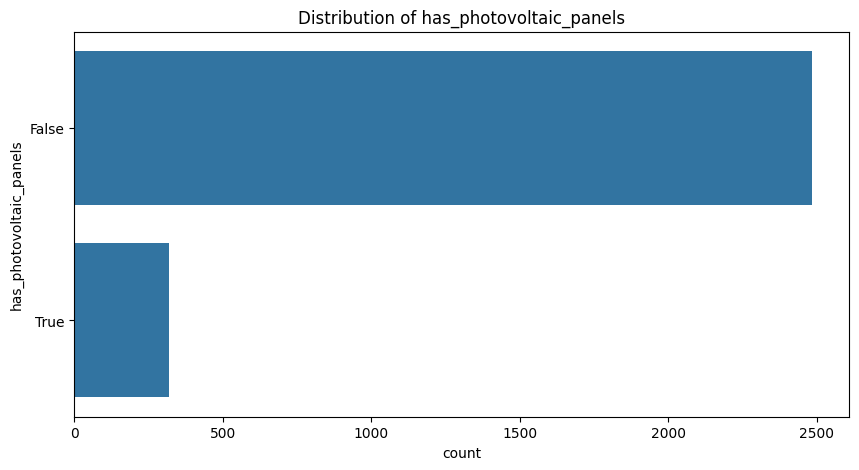

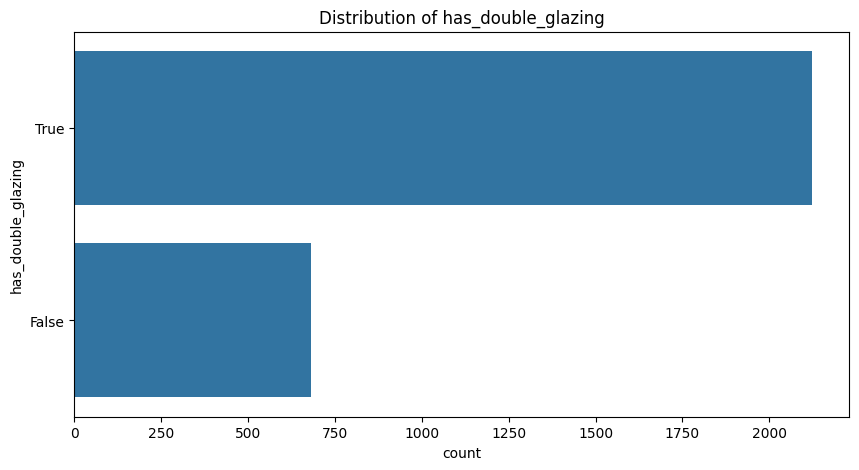

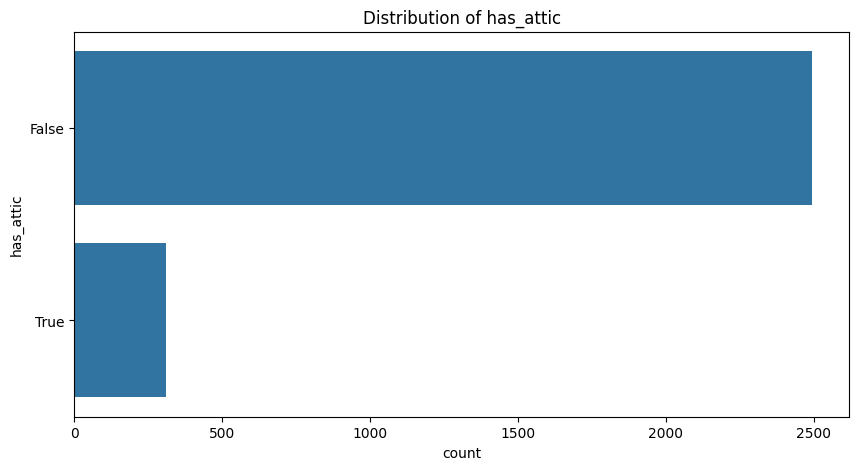

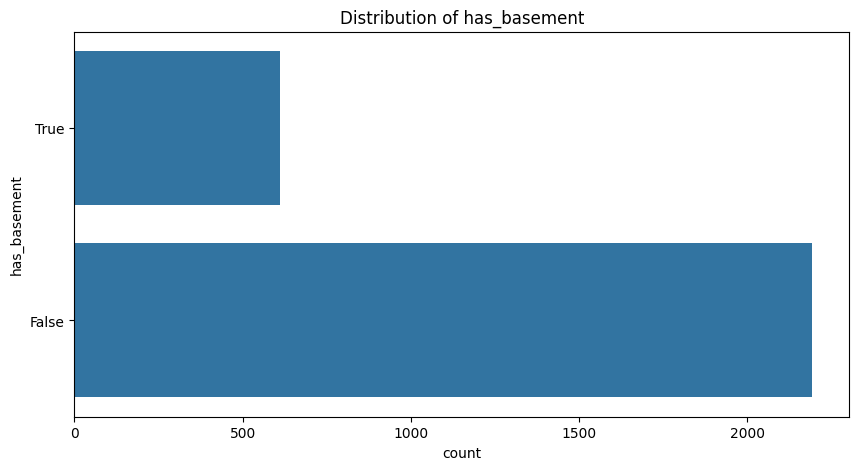

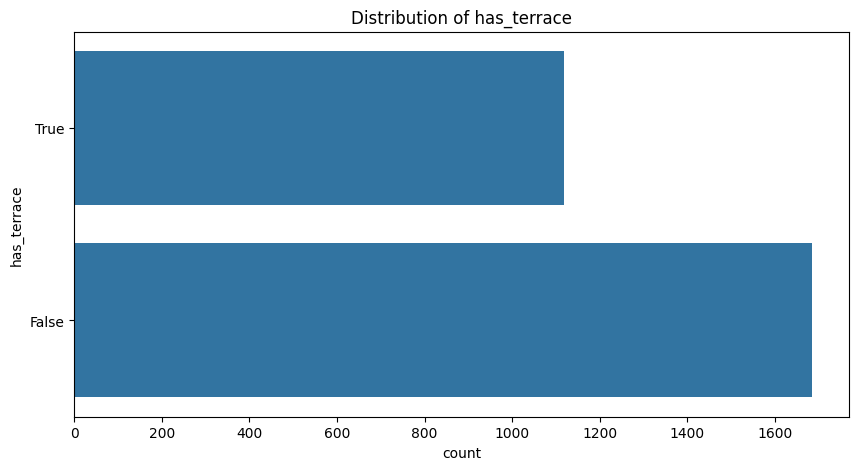

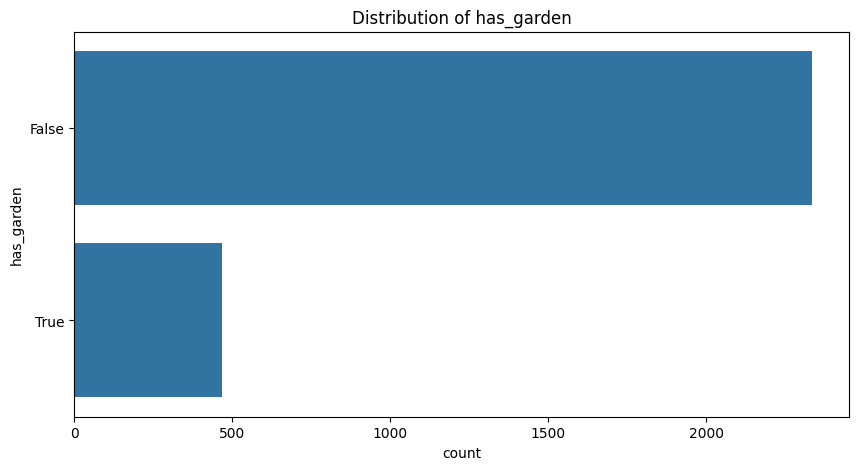

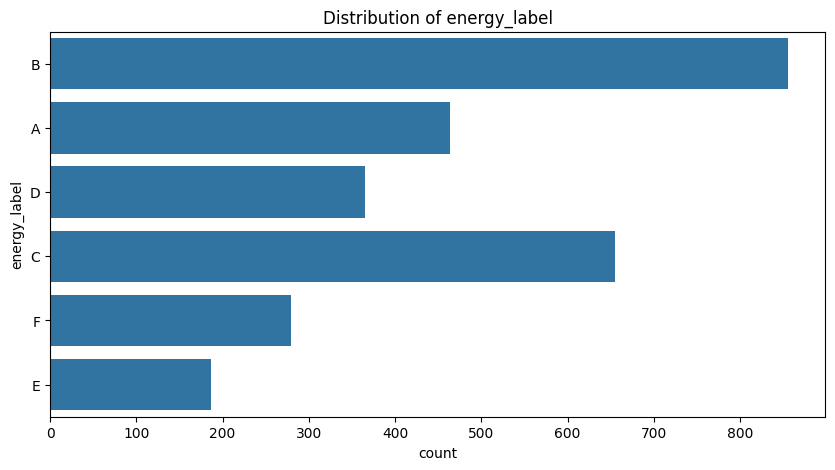

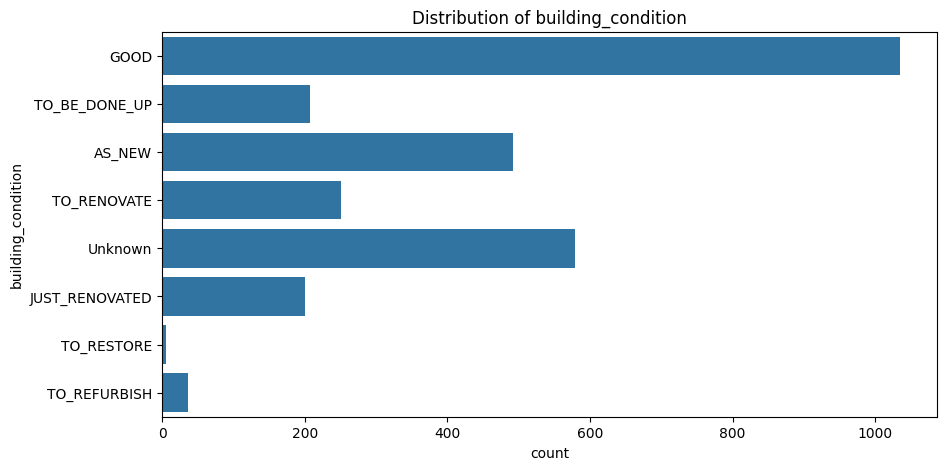

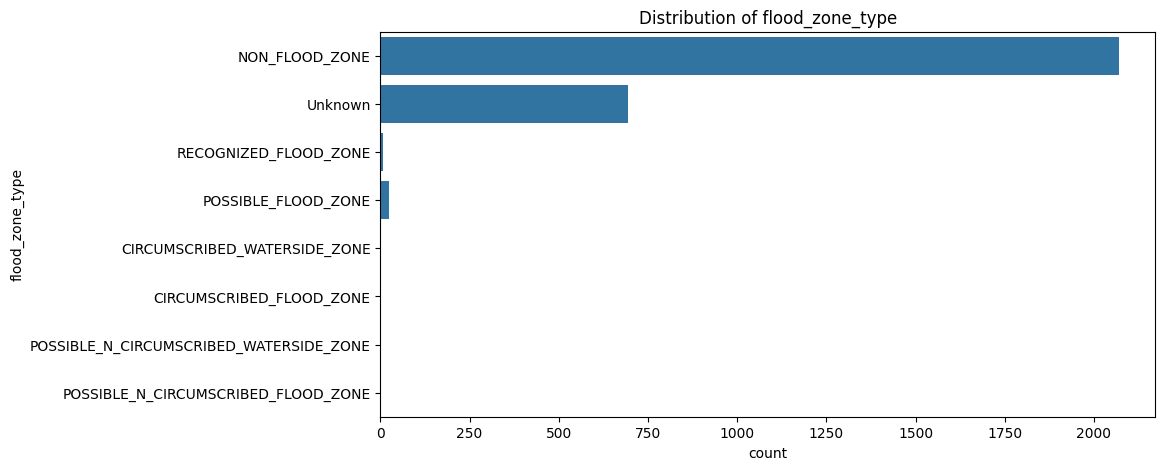

In [373]:
# Display basic information
df.info()

# Display statistical summary
display(df.describe(include='all'))

# Display missing values for each column
display(df.isnull().sum())

# Display data distribution for numerical columns
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
for column in numerical_cols:
    plt.figure(figsize=(10, 5))
    df[column].hist(bins=30)
    plt.title(f'Distribution of {column}')
    plt.show()

# Display correlation matrix
plt.figure(figsize=(15, 10))
correlation_matrix = df[numerical_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

# Display data distribution for categorical columns
for column in df.select_dtypes(include=['object']).columns:
    plt.figure(figsize=(10, 5))
    sns.countplot(data=df, y=column)
    plt.title(f'Distribution of {column}')
    plt.show()

(array([   0.,    0.,    0.,    0.,    0., 2805.,    0.,    0.,    0.,
           0.]),
 array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5]),
 <BarContainer object of 10 artists>)

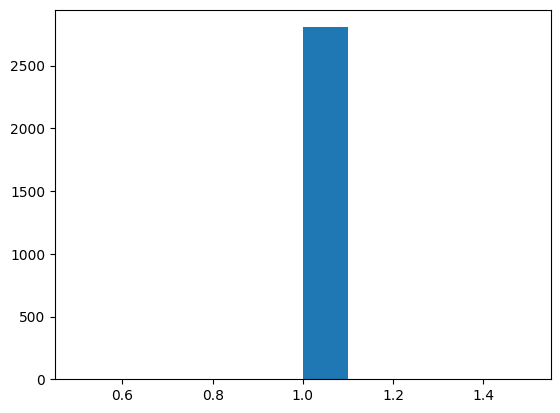

In [374]:
lengths = []
for i, d in df.groupby('property_id'):
    lengths.append(len(d))

plt.hist(lengths)

In [375]:
df = pp.preprocess(df)
df

KeyError: "['has_dining_room', 'number_of_rooms', 'total_floors', 'floor_number'] not found in axis"

In [ ]:
df['date_obtained'] = pd.to_datetime(df['date_obtained'], format='%d%m%Y')

In [ ]:
df

,property_id,date_obtained,price,property_type,livable_area,heating_type,has_photovoltaic_panels,has_double_glazing,number_of_rooms,number_of_bathrooms,number_of_bedrooms,number_of_toilets,has_living_room,has_dining_room,has_attic,has_basement,has_terrace,terrace_surface,has_garden,garden_surface,energy_label,primary_energy_consumption,postal_code,latitude,longitude,year_built,building_condition,floor_number,total_floors,property_size,flood_zone_type,cadastral_income
0,11417587,2024-06-13,0.442259,APARTMENT,103.0,Unknown,False,True,1.0,1.0,2,1.0,True,NaN,False,False,True,29.0,False,0.0,Unknown,NaN,9052,51.016958,3.694515,2023.0,GOOD,NaN,NaN,NaN,NON_FLOOD_ZONE,0
1,11417587,2024-05-31,0.442259,APARTMENT,103.0,Unknown,False,True,1.0,1.0,2,1.0,True,NaN,False,False,True,29.0,False,0.0,Unknown,NaN,9052,51.016958,3.694515,2023.0,GOOD,NaN,NaN,NaN,NON_FLOOD_ZONE,0
2,11417587,2024-06-11,0.442259,APARTMENT,103.0,Unknown,False,True,1.0,1.0,2,1.0,True,NaN,False,False,True,29.0,False,0.0,Unknown,NaN,9052,51.016958,3.694515,2023.0,GOOD,NaN,NaN,NaN,NON_FLOOD_ZONE,0
3,11417587,2024-06-14,0.442259,APARTMENT,103.0,Unknown,False,True,1.0,1.0,2,1.0,True,NaN,False,False,True,29.0,False,0.0,Unknown,NaN,9052,51.016958,3.694515,2023.0,GOOD,NaN,NaN,NaN,NON_FLOOD_ZONE,0
4,11417587,2024-06-19,0.442259,APARTMENT,103.0,Unknown,False,True,1.0,1.0,2,1.0,True,NaN,False,False,True,29.0,False,0.0,Unknown,NaN,9052,51.016958,3.694515,2023.0,GOOD,NaN,NaN,NaN,NON_FLOOD_ZONE,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50901,11480624,2024-07-20,0.425000,HOUSE,141.0,GAS,False,False,NaN,1.0,3,2.0,False,NaN,False,False,False,0.0,False,0.0,B,110.0,9940,51.139797,3.764075,2009.0,AS_NEW,NaN,3.0,440.0,Unknown,791
50902,11480624,2024-06-24,0.425000,HOUSE,141.0,GAS,False,False,NaN,1.0,3,2.0,False,NaN,False,False,False,0.0,False,0.0,B,110.0,9940,51.139797,3.764075,2009.0,AS_NEW,NaN,3.0,440.0,Unknown,791
50903,11480624,2024-06-21,0.425000,HOUSE,141.0,GAS,False,False,NaN,1.0,3,2.0,False,NaN,False,False,False,0.0,False,0.0,B,110.0,9940,51.139797,3.764075,2009.0,AS_NEW,NaN,3.0,440.0,Unknown,791
50904,11480624,2024-06-26,0.425000,HOUSE,141.0,GAS,False,False,NaN,1.0,3,2.0,False,NaN,False,False,False,0.0,False,0.0,B,110.0,9940,51.139797,3.764075,2009.0,AS_NEW,NaN,3.0,440.0,Unknown,791
